# INTRODUÇÃO

Para executar as simulações presentes nesse trabalho, utilizei *jupyter notebook*, que é uma IDE de Python para Data Science. Disponibilizerei o pdf gerado pelo notebook e também deixarei o *.ipynb* para que possa ser executado por qualquer um. Para isso algumas instruções:

1. Acesse qualquer interpretador .ipynb — o mais fácil é o google colab → https://colab.research.google.com/ — e faça o upload do arquivo;
2. Primeiro execute o último bloco desse notebook — lá no fim, chamado 'Funções feitas sob medida para simulação' — para carregar as funções utilziadas ao longo das análises.

Existem diversos motivos para utilizar Python em análise de sistemas e gostaria de defender alguns pontos. Há muitas bibliotecas científicas que são abertas ao uso e podem ser fácilmente instaladas com o uso da diretiva **import**. O que torna essa ferramenta tão poderosa é a enorme comunidade envolvida, que está sempre evoluindo a capacidade da ferramenta. Python é usado para tudo! Para tudo existe uma biblioteca que respeita as convenções da linguagem, ou seja, é uma maneira perfeita de interoperar áreas do conhecimento.

É fato que é mais prático usar MATLAB para ações pontuais — no contexto dessas simulações com certeza seria. Entretanto no final das contas, o Python vai fornecer um canhão de ferramentas poderosas para gerar outros tipos de análises matemáticas no contexto de controle. Eu poderia, por exemplo:

- Posso processar uma grande massa de dados empíricos com muito mais facilidade e velocidade;
- Posso "anexar" modelos de aprendizagem de máquina às funções de transferência ou espaços de estados;
- Posso — e essa talvez seja a coisa mais interessante — embarcar minhas funções em dispositivos com muita facilidade.

Por isso, é um bom investimento de tempo se envolver com Python. Abaixo, eu construi algumas funções sob medida para essas simulações. O meu objetivo foi simplesmente acelerar os cálculos, pois muitas vezes temos que corrigir erros o que leva muito tempo. É mais fácil fazer isso ajustando parâmetros.

# QUESTÃO 1

## <font style='font-size: 20px;'> Obtendo polos e informações da função </font> <hr style='line: 2px solid;'>

A função de transferência média dos dados “a5.csv” : 

$$ G(s) = 1.3885 \cdot \frac{20.223}{s^2 + 3s + 20.223} $$

In [2]:
G = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)
G['dados']


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,43.14319,NaN,6.380678


## <font style='font-size: 20px;'> Simulação de Bode </font> <hr style='line: 2px solid;'>

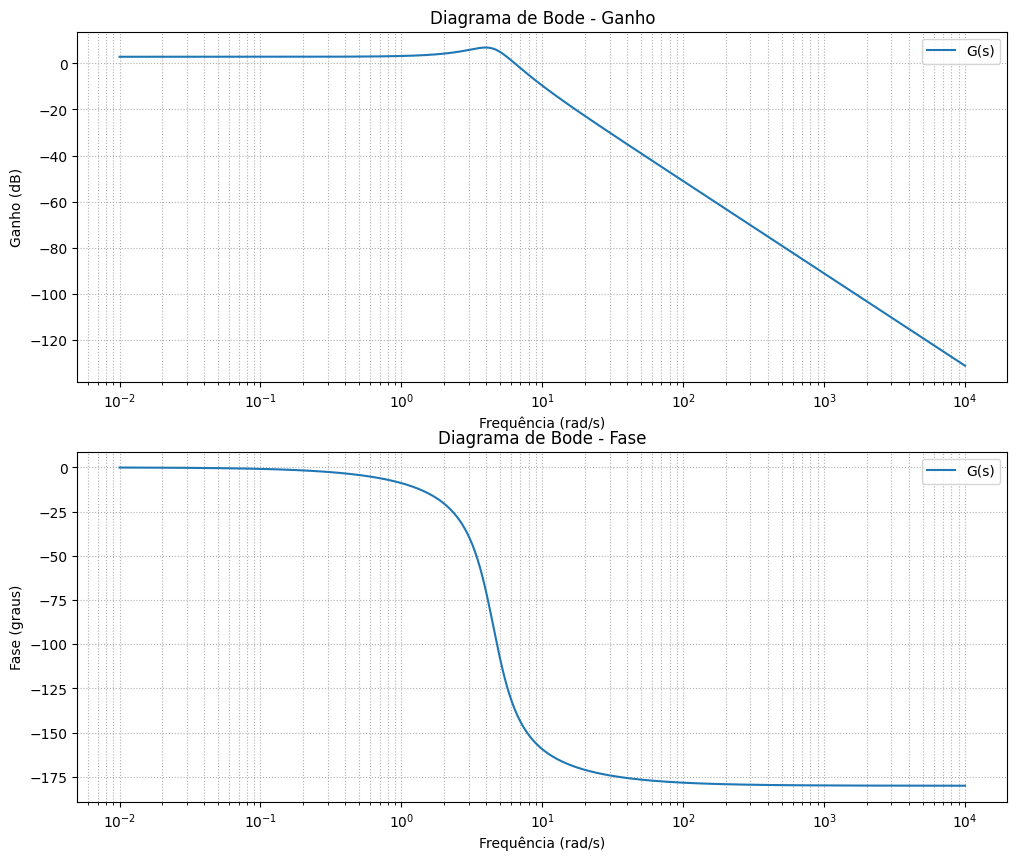

In [4]:
obter_plot_bode({'G(s)':G['scipy']})

Segundo Ogata (pag 427, cap 7):


    "A margem de ganho de um sistema de primeira ou de segunda ordens é infinita, visto que os diagramas polares para esses sistemas não cruzam o eixo real negativo"

Consequentemente não haverá frequência de crossover. Além disso, podemos ver na imagem abaixo que a margem de fase é realmente $\approx 45° $ e a frequência desse valor realmente está em torno de $5.5 \frac{\omega}{seg}$

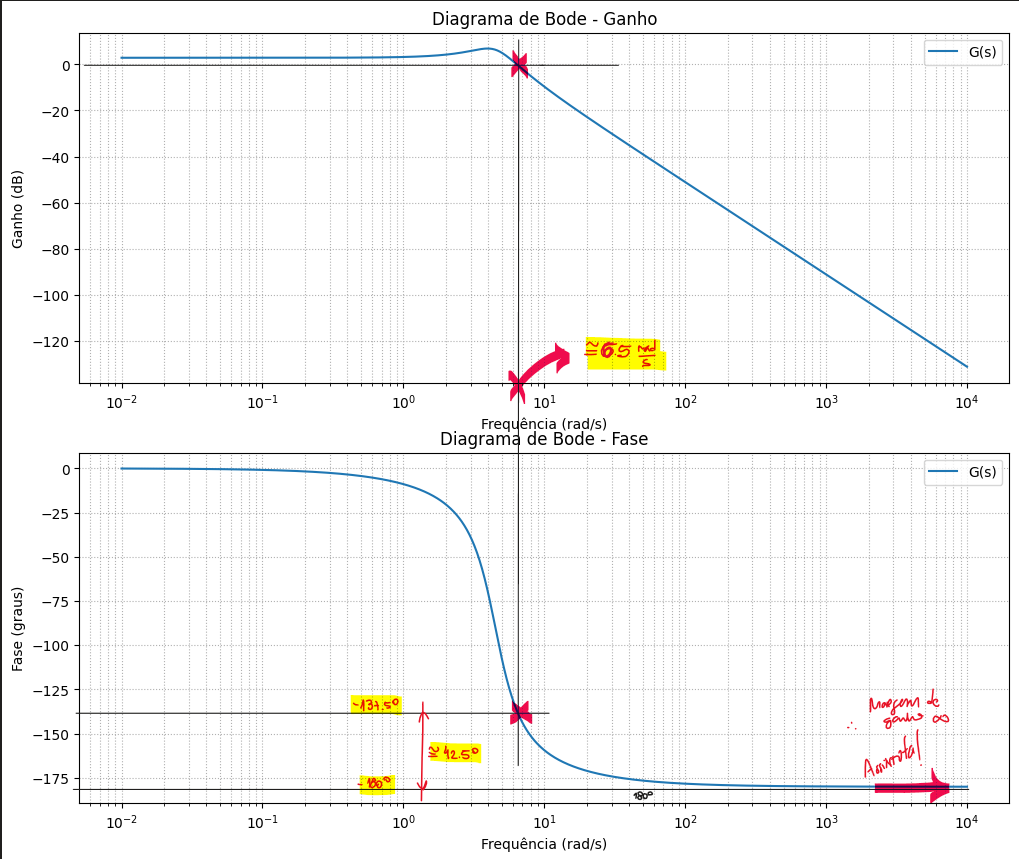

## <font style='font-size: 20px;'> Simulação de Nyquist </font> <hr style='line: 2px solid;'>

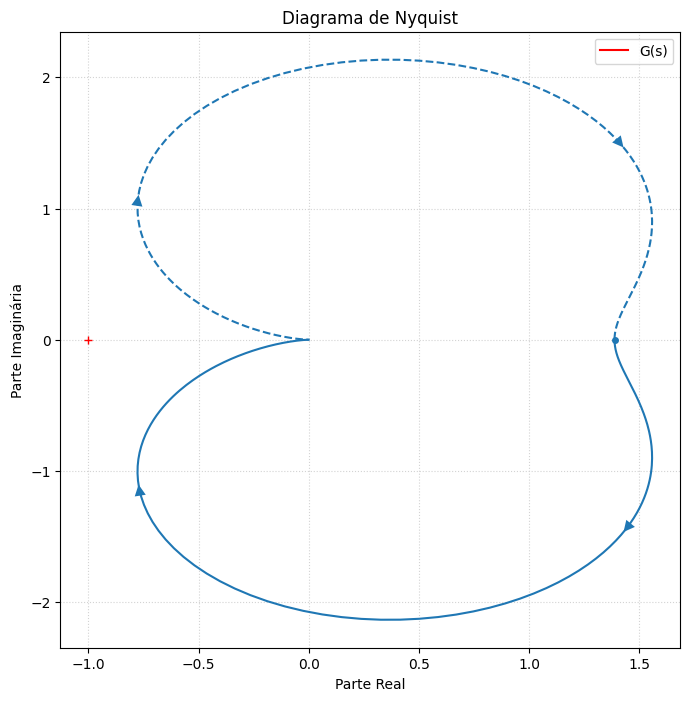

In [6]:
obter_plot_nyquist({'G(s)':G['control']})

O plot de Nyquist concorda perfeitamente com o diagrama de Bode. Apesar da circunferência estar deformada pelas dimensões do gráfico, podemos ver que o sistema é do tipo 0, temos 2 polos e temos uma margem de fase de aproximadamente $45°$. Não importa o ganho, o gráfico não abraçará $-1$. 

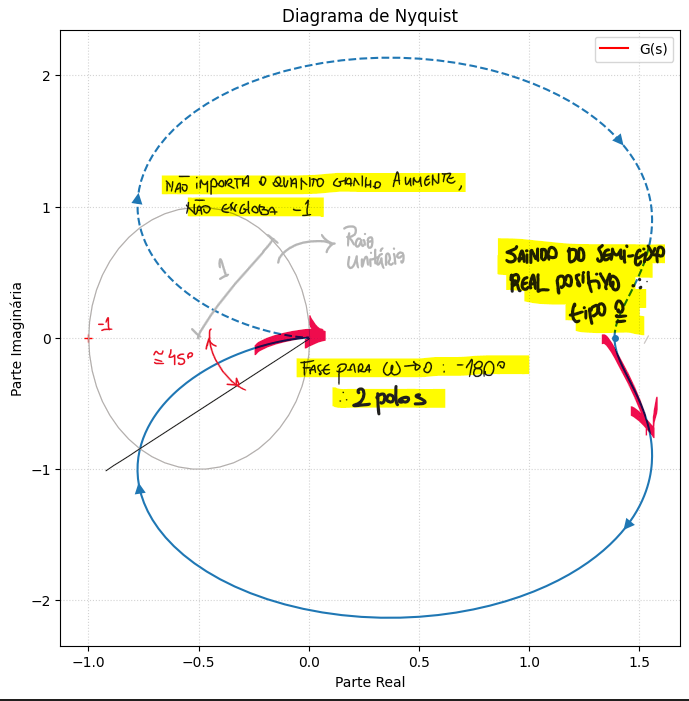

# QUESTÃO 2 

## <font style='font-size: 20px;'> Simulação de diversos ganhos </font> <hr style='line: 2px solid;'>

Como dito na questão anterior, a margem de ganho é infinita. A única forma desse sistema se tornar instável é através da fase. Faremos o seguinte para mostrar isso, na simulação do plot de Nyquist abaixo, 3 plots são feitos, para ganhos 1, 10 e 100. Isso mostra o comportamento assinstótico. É possível ver o comportamento assintótico do plot de nyquist, ele entra com ângulo -180.

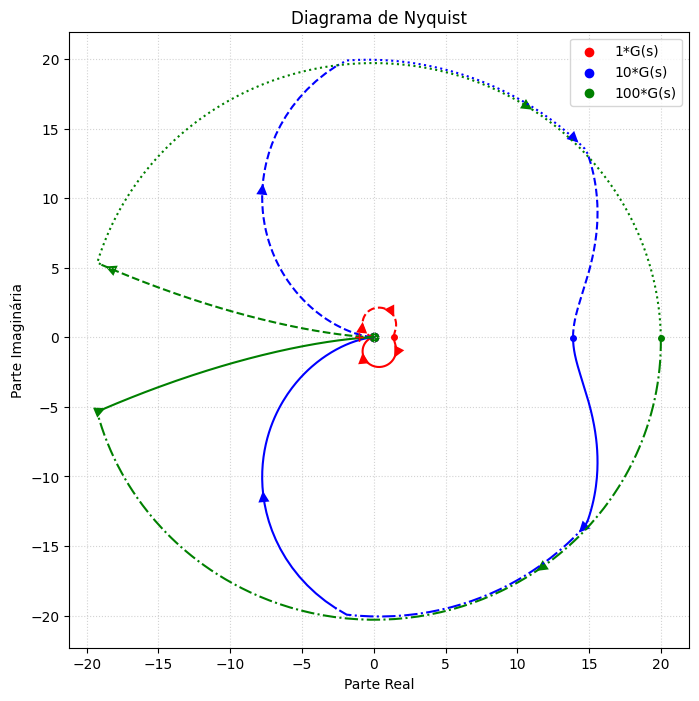

In [35]:
obter_plot_nyquist({'1*G(s)':G['control'], '10*G(s)':10*G['control'], '100*G(s)':100*G['control']})


# QUESTÃO 3 

## <font style='font-size: 20px;'> Obter dados A5 </font> <hr style='line: 2px solid;'>

In [40]:
a5 = obter_dados_a5()
a5

,Sobressinal,Coeficiente de Amortecimento (ζ),Frequência Natural não Amortecida (ω_d),Frequência Natural Amortecida (ω_n),Ganho
Média,0.330111,0.334555,4.778245,4.497064,1.388502
Valor Máximo,0.394422,0.402900,7.445800,6.981300,2.322430
Variação Máxima,0.064312,0.068345,2.667555,2.484236,0.933928


O que farei é o seguinte, vou gerar 3 diagramas de Bode e 3 diagramas plots de Nyquist variando sempre somente um parâmetro, do seu valor médio para seu valor máximo.

Ao fazer isso, veremos que o o único parâmetro que parece afetar significativamente a margem de fase — a marge de ganho se mostrou inalterada para qualquer manipulação — é o ganho. O coeficiente de amortecimento, $\zeta$, com certeza tem grande poder de influência, visto que uma mudança de $0.07$ já provocou aumento de margem de fase também.


## <font style='font-size: 20px;'> Variação do ganho </font> <hr style='line: 2px solid;'>


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j

        46.97
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


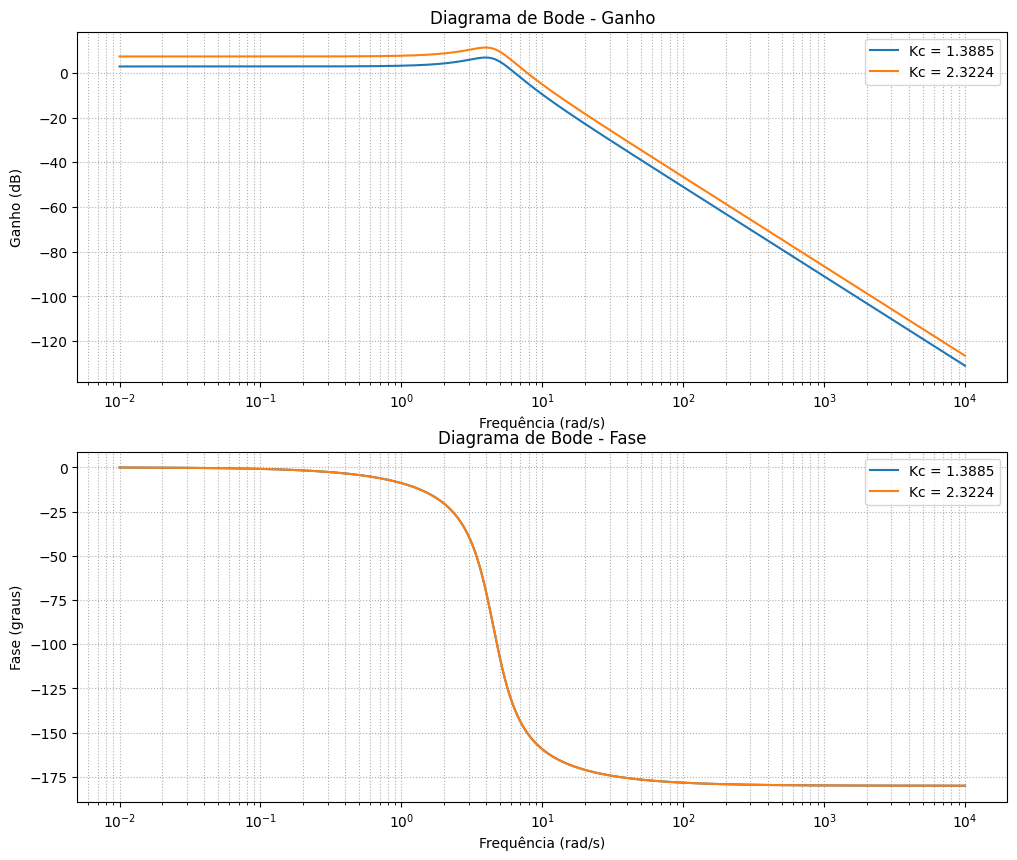

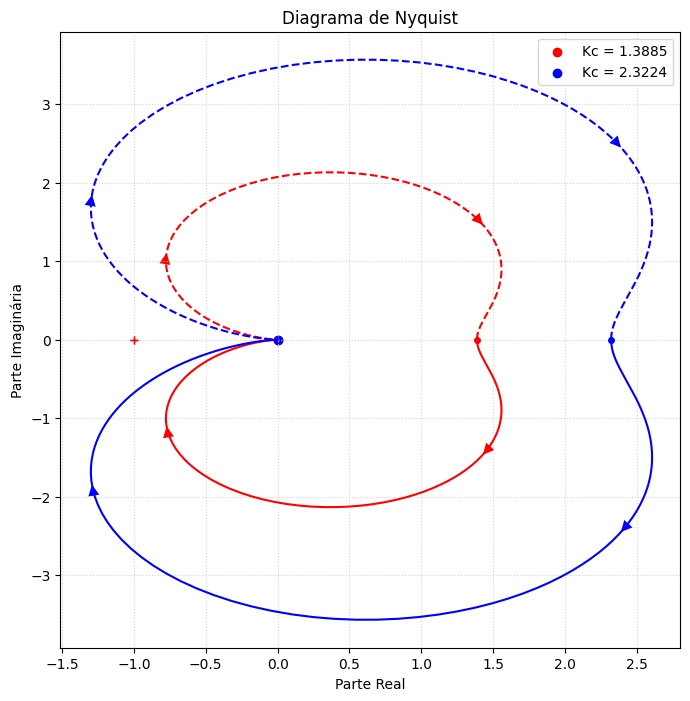

In [44]:
G_k1 = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)
G_k2 = obter_sistema(zeta=0.3346, wn=4.4971, k=2.3224)

obter_plot_bode({'Kc = 1.3885':G_k1['scipy'], 'Kc = 2.3224':G_k2['scipy']})
obter_plot_nyquist({'Kc = 1.3885':G_k1['control'], 'Kc = 2.3224':G_k2['control']})

## <font style='font-size: 20px;'> Variação do coeficiente de amortecimento </font> <hr style='line: 2px solid;'>


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j

        28.08
---------------------
s^2 + 3.624 s + 20.22

Zeros:
Polos:
-1.8119+4.1159j
-1.8119-4.1159j


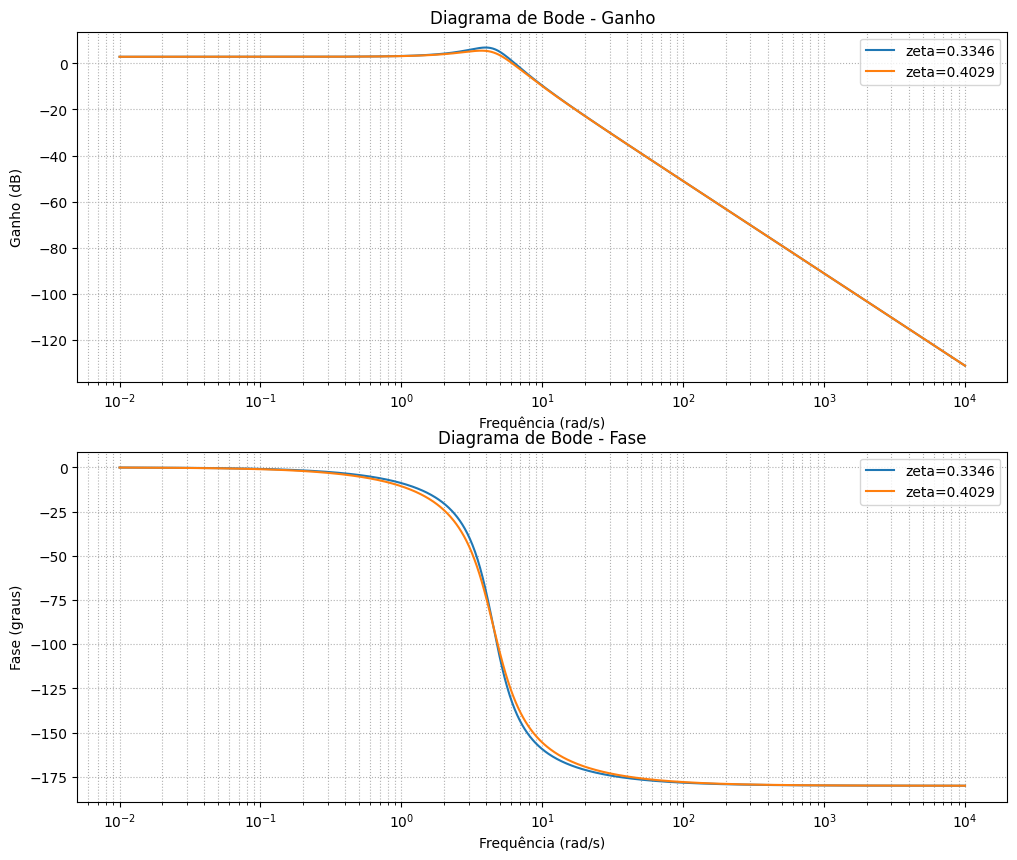

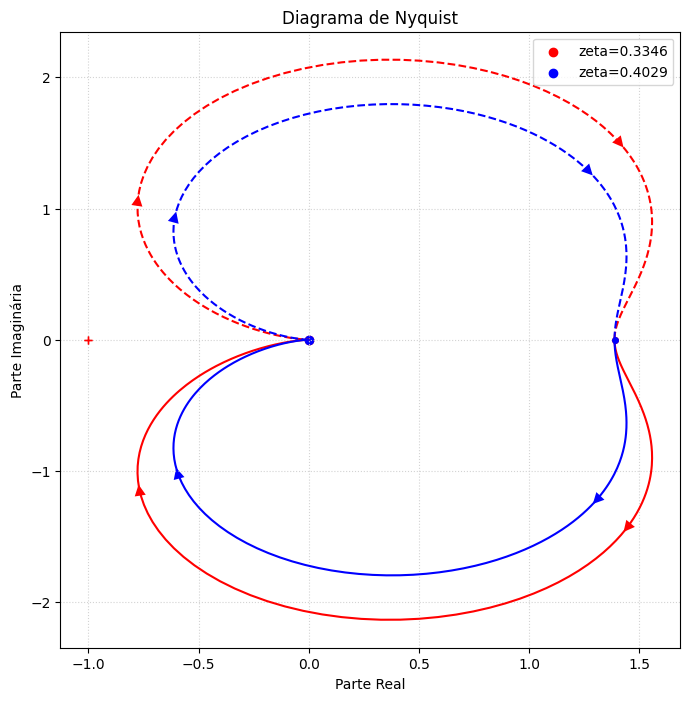

In [45]:
G_k1 = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)
G_k2 = obter_sistema(zeta=0.4029, wn=4.4971, k=1.3885)

obter_plot_bode({'zeta=0.3346':G_k1['scipy'], 'zeta=0.4029':G_k2['scipy']})
obter_plot_nyquist({'zeta=0.3346':G_k1['control'], 'zeta=0.4029':G_k2['control']})

## <font style='font-size: 20px;'> Variação do frequência amortecida </font> <hr style='line: 2px solid;'>


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j

        67.67
---------------------
s^2 + 4.672 s + 48.74

Zeros:
Polos:
-2.3359+6.5789j
-2.3359-6.5789j


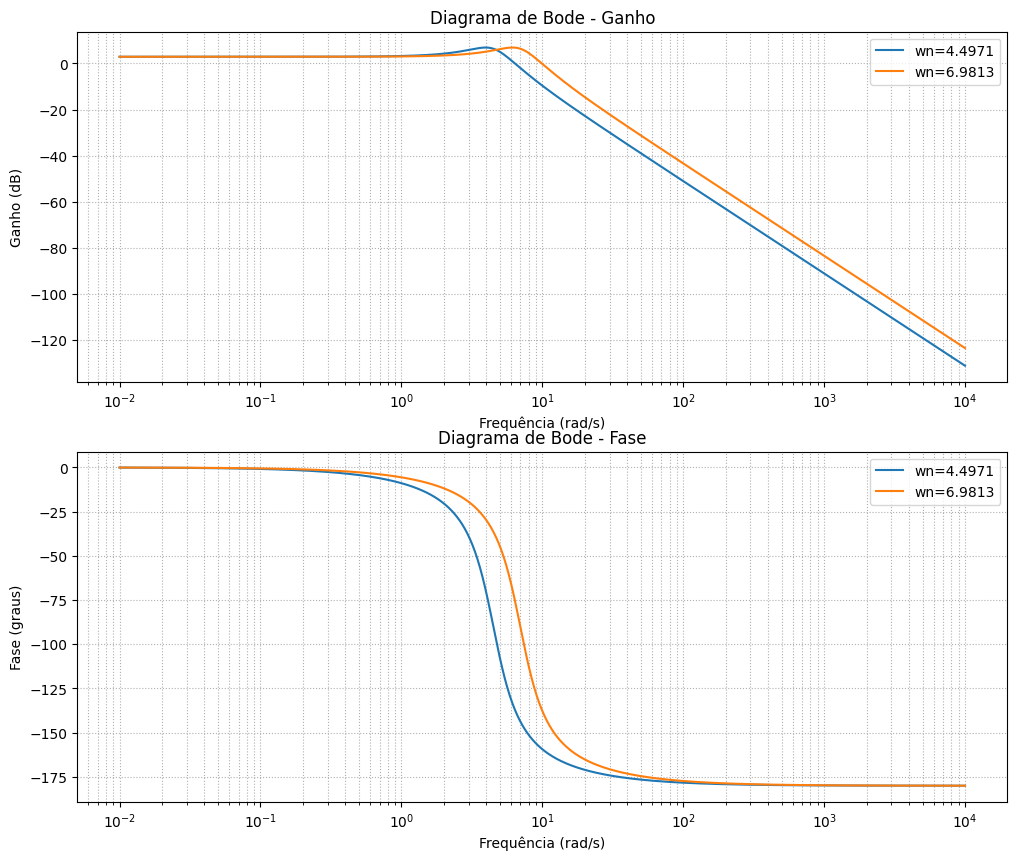

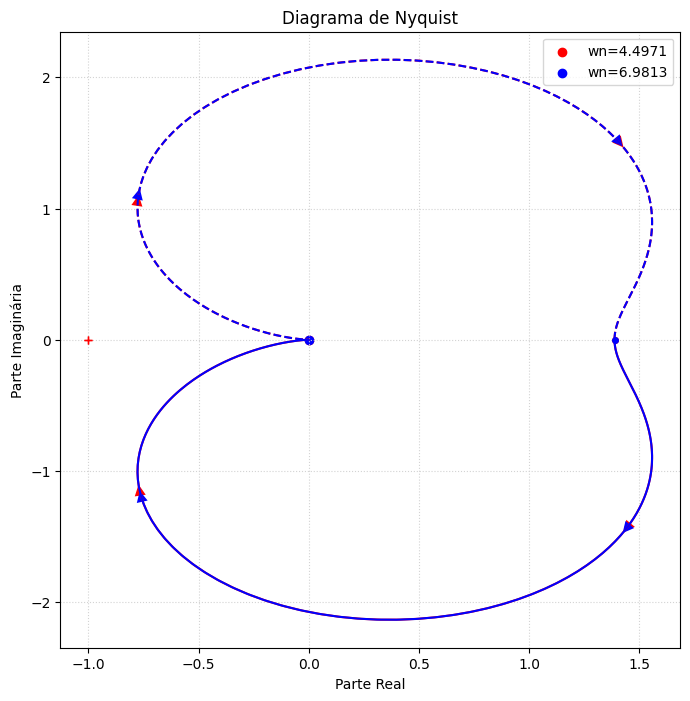

In [46]:
G_k1 = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)
G_k2 = obter_sistema(zeta=0.3346, wn=6.9813, k=1.3885)

obter_plot_bode({'wn=4.4971':G_k1['scipy'], 'wn=6.9813':G_k2['scipy']})
obter_plot_nyquist({'wn=4.4971':G_k1['control'], 'wn=6.9813':G_k2['control']})

# QUESTÃO 4.a

## <font style='font-size: 20px;'> O sistema tal como é  </font> <hr style='line: 2px solid;'>

Aqui vamos somente reproduzir a função e obter algumas informações 
inclundo o erro no estado estacionário.

In [44]:
G = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


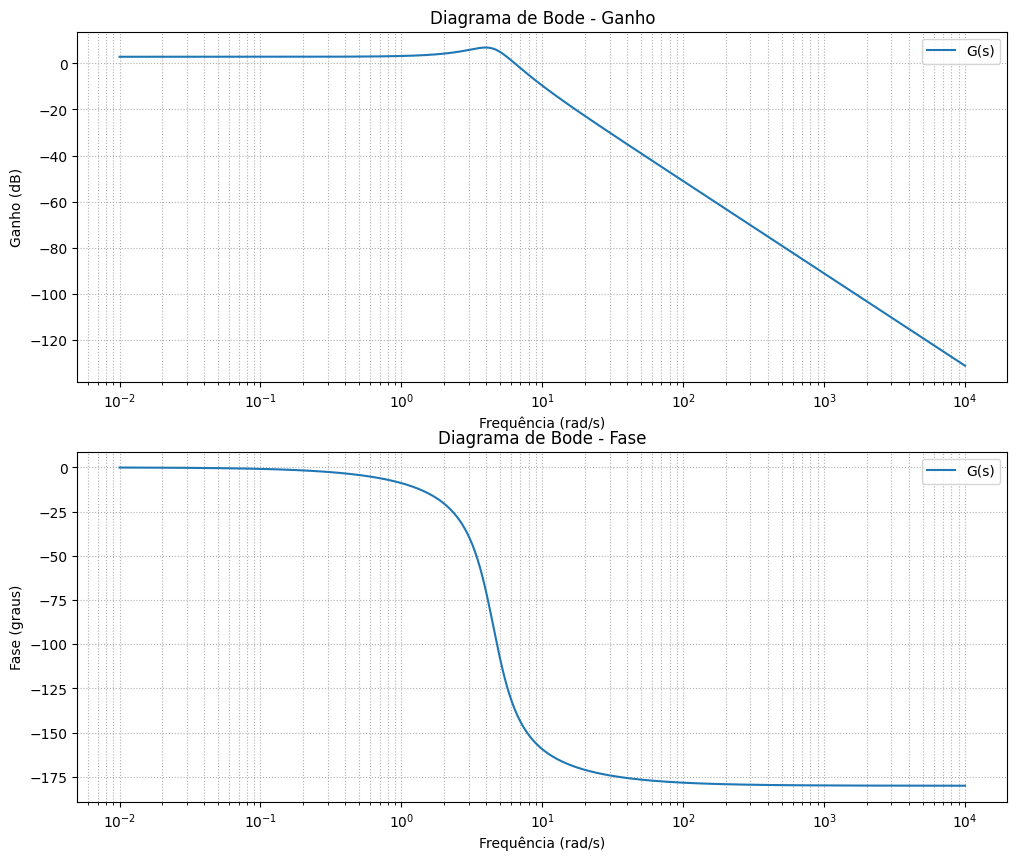

In [45]:
obter_plot_bode({"G(s)":G['scipy']})

In [56]:
obter_informacoes_bode(num=[28.08],den=[1, 3.009, 20.22])

,Pico de ressonância (dB),Frequência do pico de ressonância (rad/s),Ganho em baixas frequências (dB),Banda de passagem (rad/s) e corte,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
0,6.8573,3.9591,1.3887,-3.9491,inf,43.1354,NaN,6.3805


## <font style='font-size: 20px;'> Garantido erro estacionário com ganho adequado </font> <hr style='line: 2px solid;'>

A primeira coisa que iremos fazer é resolver nosso requisito de erro no estado estacionário. Ele é calculado para degrau unitário e é proporcional a uma constante $K_p$, em sistemas do tipo 0 — que é o caso. Logo:

$$e_{ss} = \frac{1}{1+K_p} → K_p = 49$$

O que acabamos de encontrar foi um *controlador proporcional*, a razão ganho natural do sistema pelo *ganho de posição*, $\frac{K}{K_p}$, produz um erro muito próximo à 0.02. Este tipo de controlador, entretanto, não consegue sintonizar corretamente a margem de fase. Por isso vamos projetar o *compensador* para tentar sintonizar, também, o requisito de margem de fase. Compensadores tem a seguinte forma:

$$ C(s) = K_c \frac{Ts+1}{\alpha Ts+1}$$

- se $\alpha < 1$, você está adicionando um *compensador de avanço de fase*;
- se $0 <\alpha < 1$, você está adicionando um *compensador de atraso de fase*;
- se $\alpha = 1$, você está adicionando um *controlador proporcional*;
- se $\alpha = 0$, você está adicionando um *zero + controlador proporcional*;

Para projetar um compensador de avanço, a primeira coisa a se fazer é determinar qual será o ganho. Isso se faz dividindo o ganho natural do sistema em malha aberta pelo ganho proporcional para o requisito de erro estacionário:

$$ K_c = \frac{K}{K_p} → \frac{1.3885}{49} → \boxed{K_c = 35.2899} $$

Com isso, temos o ganho do nosso compensador. Nosso novo sistema será:

In [58]:
KcG = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885*35.2899)


         991
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


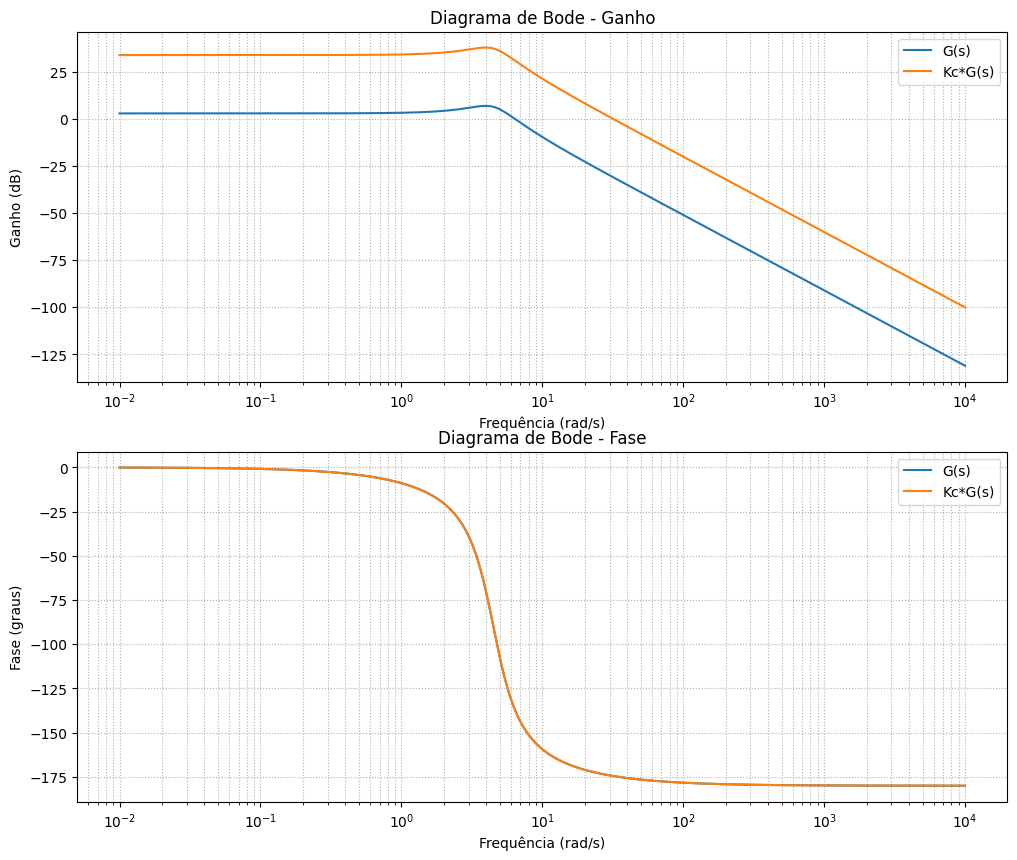

In [59]:
obter_plot_bode({"G(s)":G['scipy'], 'Kc*G(s)':KcG['scipy']})

## <font style='font-size: 20px;'> Definição dos parâmetros baseado na fase necessária </font> <hr style='line: 2px solid;'>

Na prática, o que fazemos é olhar para o nosso instrumento de análise, o *Diagrama de Bode* — preferível ao *Plot de Nyquist* por ser uma superposição gráfica dos elementos que compõe o sistema. Aqui, vamos usar cálculo numérico para isso (os plots só virão ao fim dos cálculos) para encontrar nossos valores. 

A função python 'calcula_bode' nos dá três critérios:

- 'frequencia' : retorna frequência, ganho e fase para o valor de frequêcia que você forneceu;
- 'ganho' : retorna frequência, ganho e fase para o valor de ganho que você forneceu;
- 'fase' : retorna frequência, ganho e fase para o valor de fase que você forneceu;

>  As unidades retornadas são $rad/s$, $dB$ e $graus$. Quanto maior a 'resolucao', maior será a precisão dos valores retornados.

Observando as *margens* do sistema, podemos ver que a frequência de margem de fase é de $\boxed{31.7267 \frac{rad}{s}}$



In [60]:
obter_valor_bode(KcG['scipy'], criterio="ganho", valor=0, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,31.878913,-174.498265,-0.084424


Na literatura (*Ogata, 5°Ed, figura 7.91*), podemos ver que o diagrama polar desse tipo de compensador fornece duas relações interessantes para cálculo, a saber:

$\phi_m$, fase máxima:
$$ \sin{\phi_m} = \frac{1-\alpha}{1+\alpha} $$

$\omega_m$, ganho máxima:
$$ |C(j\omega_m)| = \frac{1}{\sqrt{\alpha}} $$

Considerando nosso requisito de fase, $55° -5.5290°+10°=59.5°$, precisamos que $\phi_m=58.5°$. Logo temos:

$$ sen (53°) = 0.0.7986 = \frac{1-\alpha}{1+\alpha} → \boxed{\alpha = 0.0743} $$

Agora, podemos calcular também o máximo de ganho que nosso compensador pode fornecer:

$$ |C(j\omega_m)| = \frac{1}{\sqrt{8.9305}} →  \boxed{|C(j\omega_m)| = 3.6686 dB}$$

Então, o que queremos é que o modulo do sistema seja $|G(j\omega)| = -3.6686 dB$, e vamos buscar a frequência para esse ganho.

In [61]:
obter_valor_bode(KcG['scipy'], criterio='ganho', valor=-3.6686, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,39.227768,-175.554808,-3.733772


Ou seja, nossa nova frequência de corte será $32.2484 \frac{rad}{s}$, pois se o cruzamento for $\omega_m$, o ganho do compesador vai zerar com o ganho do sistema. Para garantir isso, precisamos encontrar o $T$ que faça isso, assim:

$$\omega_m = \frac{1}{\sqrt{\alpha}T} → \boxed{T = 0.0103}$$

Logo nosso compensador será:

In [62]:
Cav = obter_compensador(alpha=0.0743, T=0.0935, kc=35.2899)


3.3 s + 35.29
--------------
0.006947 s + 1

Zeros:
-10.6952+0.0000j
Polos:
-143.9460+0.0000j


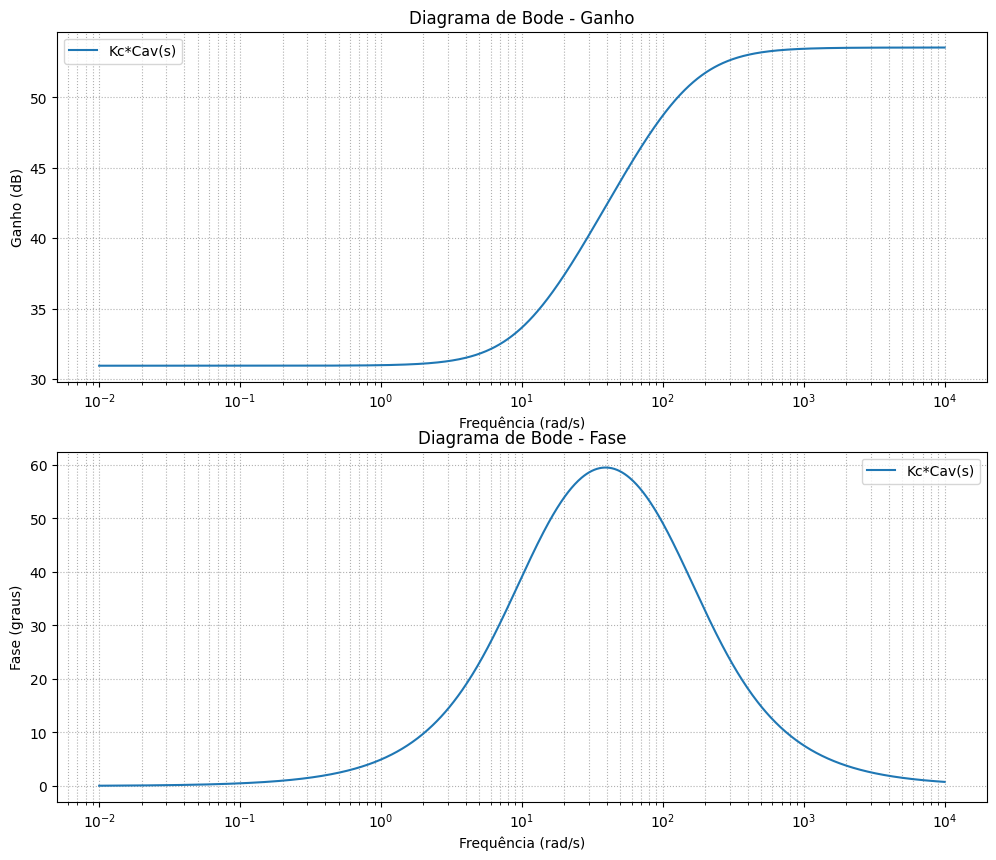

In [63]:
obter_plot_bode({"Kc*Cav(s)":Cav['scipy']})

## <font style='font-size: 20px;'> Simulação e plot do compensador de avanço </font> <hr style='line: 2px solid;'>

Forma padrão:
**************

   1.334e+04 s + 1.426e+05
------------------------------
s^3 + 147 s^2 + 453.4 s + 2911

Zeros:
-10.6952+0.0000j
Polos:
-143.9460+0.0000j
-1.5047+4.2379j
-1.5047-4.2379j

              92.66 s + 991
-----------------------------------------
0.006947 s^3 + 1.021 s^2 + 3.15 s + 20.22



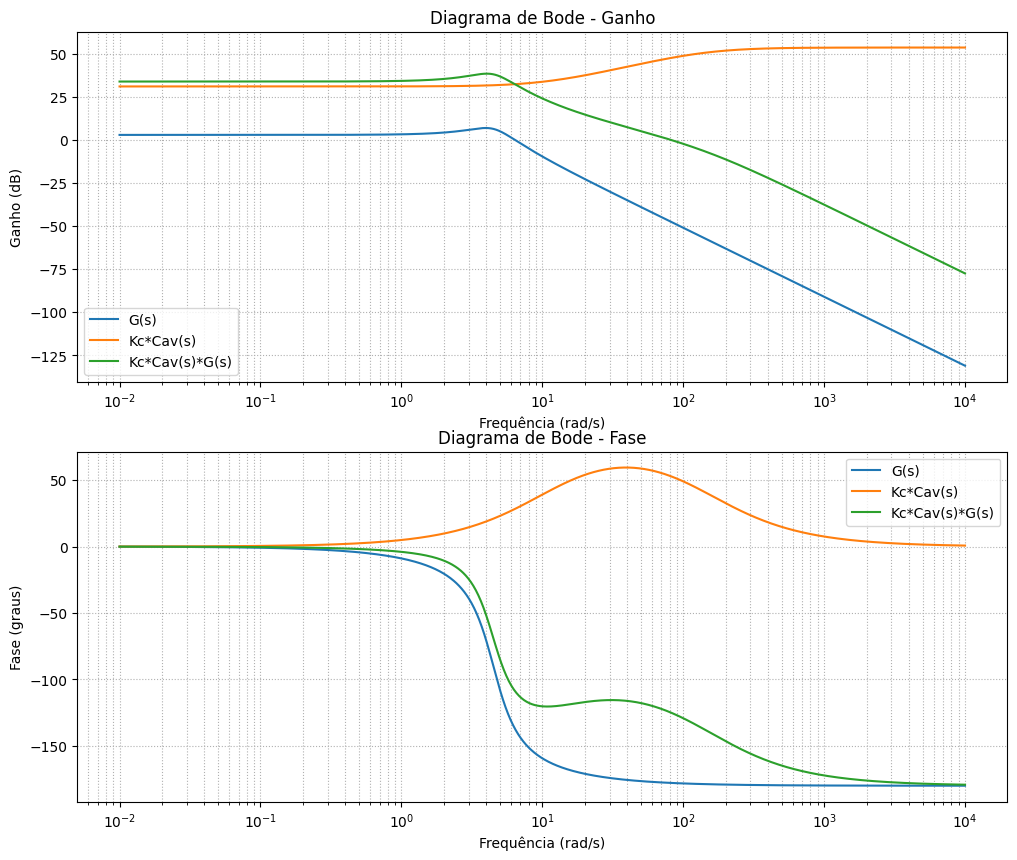

In [72]:
Kc_Cav_G = obter_malha([Cav['scipy'], G['scipy']], scipy=True)
obter_plot_bode({'G(s)':G['scipy'], 'Kc*Cav(s)':Cav['scipy'], 'Kc*Cav(s)*G(s)':Kc_Cav_G['scipy']})
print(Cav['control']* G['control'])


In [65]:
obter_sistema(num=[92.66, 991], den=[0.007, 1.021, 3.15, 20.22])


            92.66 s + 991
--------------------------------------
0.007 s^3 + 1.021 s^2 + 3.15 s + 20.22

Zeros:
-10.6950+0.0000j
Polos:
-142.8485+0.0000j
-1.5043+4.2377j
-1.5043-4.2377j


{'scipy': TransferFunction(array([ 92.66, 991.  ]), array([7.000e-03, 1.021e+00, 3.150e+00, 2.022e+01])),
 'control': TransferFunction(array([ 92.66, 991.  ]), array([7.000e-03, 1.021e+00, 3.150e+00, 2.022e+01]))}

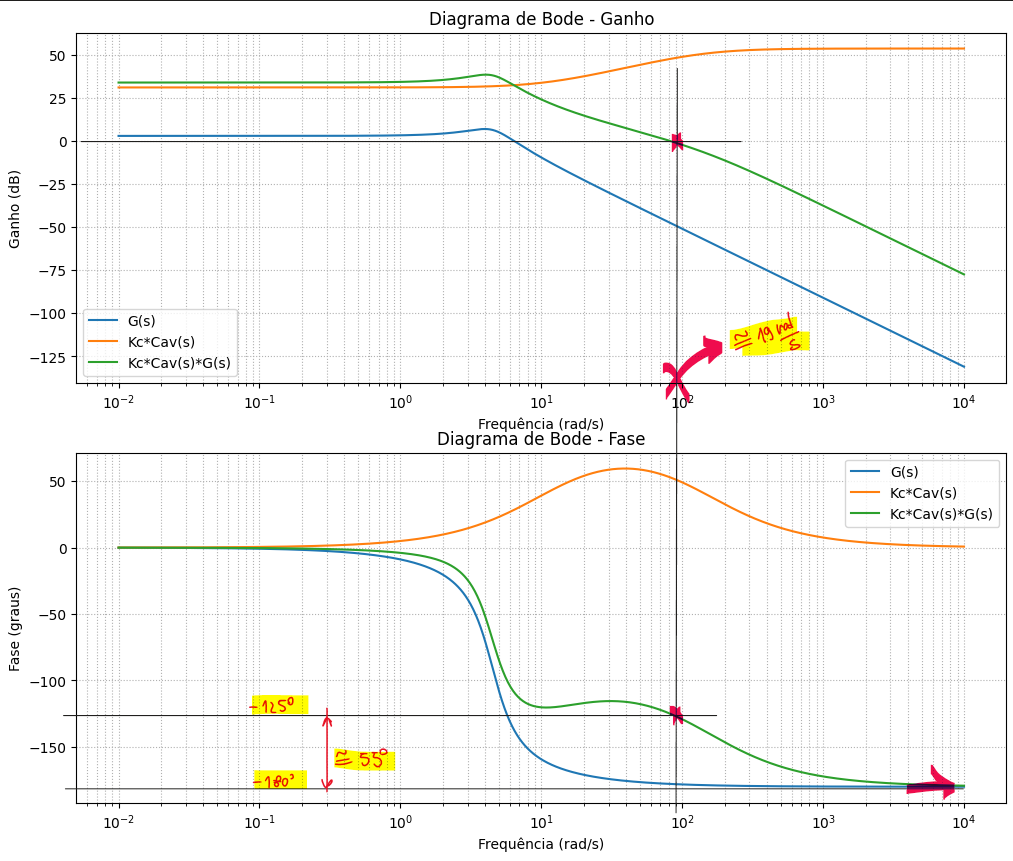

## <font style='font-size: 20px;'> Malha fechada </font> <hr style='line: 2px solid;'>

Nossa malha fechada será:

In [145]:
malha_fechada_avanco = obter_malha([G['control'], Cav['control']], close=True) # obter cascata da malha e fechar ela
obter_parametros_sistema(sys=malha_fechada, acomodacao=0.05) # obter parametros da resposta ao degrau para malha fechada com ts em %5



              92.66 s + 991
-----------------------------------------
0.006947 s^3 + 1.021 s^2 + 95.81 s + 1011

Zeros:
-10.6952+0.0000j
Polos:
-67.5011+87.2969j
-67.5011-87.2969j
-11.9533+0.0000j


,Valor
RiseTime,0.0143
SettlingTime,0.0694
SettlingMin,0.9344
SettlingMax,1.1637
Overshoot,18.7406
Undershoot,0.0000
Peak,1.1637
PeakTime,0.0347
SteadyStateValue,0.9800
Erro(%),0.02


[1.00000000e-02 1.00115207e-02 1.00230547e-02 ... 9.97699834e+02
 9.98849255e+02 1.00000000e+03]


,Pico de ressonância (dB),Frequência do pico de ressonância (rad/s),Ganho em baixas frequências (dB),Banda de passagem (rad/s)
0,1.1268,56.9345,0.98,-56.9245


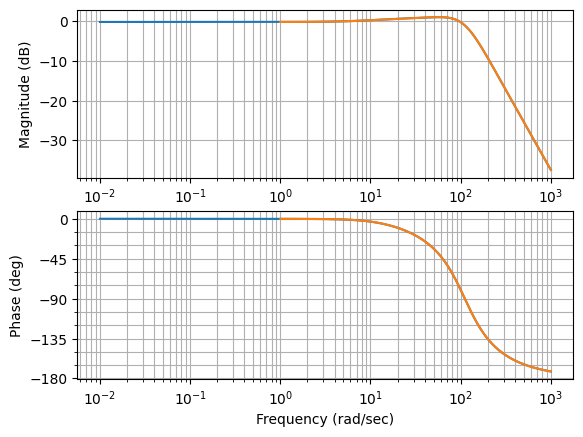

In [141]:
info = obter_informacoes_bode(malha_fechada_avanco)

# mag_ct, phase_ct, omega_ct = ct.bode(malha_fechada_avanco, Hz=False, dB=True)
# malha_fechada_avanco_sc = obter_cascata()
# mag_sc, phase_sc, omega_sc = signal.bode(malha_fechada_avanco, Hz=False, dB=True)

# QUESTÃO 4.b

## <font style='font-size: 20px;'> Cálculo do compensador de atraso </font> <hr style='line: 2px solid;'>

O *compensador de atraso* faz é interessante quando já temos o ganho ajustado ao erro e só queremos garantir a margem de fase em uma frequência específica. Na prática, vamos atrasar a fase para que a frequência de corte ocorra no início da transitório original.

Se você subtrair: $-180° + MF = \theta$. 

$\theta$ será a fase onde você terá sua margem de fase desejada. A partir dela você pode encontrar qual deve ser sua frequência de corte. No nosso caso, $-180°+55°=-125°$ e acrescentaremos 8° por recomendação da literatura — no compensador de avanço, ajustamos para 10° além do requisito. $K_c = 35.2899$.

In [70]:
obter_valor_bode(KcG['scipy'], criterio="fase", valor=-117, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,5.342293,-117.350678,34.767229


A função 'calcular_bode' retornou os valores de frequência, fase e ganho, para a fase $-117°$. 

> Mas de todo o caso, o que se faz é observar gráfico e traçar uma linha para a margem de fase que precisa, identificando com isso, onde o ganho que precisaria estar para produzir essa margem de fase. Com isso você pode calcular a queda de ganho necessária.

No nosso caso, a frequência está por volta de $5.3 \frac{rad}{s}$. Considerando esse ponto, precisamos de um ganho $-34.7672 dB$, para cancelar com o ganho e ter o frequência de corte nessa fase. Ou seja: 

$$ 20\:\log _{10}  |C(j\omega)| = -34.7672 → |C(j\omega)| = 0.0182$$ 

Sabe-se que em *altas frequências*, o ganho de nosso controlador se resume a $\frac{1}{a}$:

$$ \frac{1}{a} = 0.0182 → a = 54.9450$$

Finalmente, nossa frequência dirá o parâmetro $T$. A prática é escolher o zero do controlador uma década abaixo (*Castrucci, cap.5.11.12*), evitando assim a diminuição da margem. Logo: 

$$ s = -\frac{1}{T} = -0.5494 → T = 1.8201$$

In [71]:
Cat = obter_compensador(alpha=54.9450, T=1.8201, kc=35.2899)
Cat['dados']


64.23 s + 35.29
---------------
   100 s + 1

Zeros:
-0.5494+0.0000j
Polos:
-0.0100+0.0000j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Compensador de atraso,inf,131.195208,NaN,0.46021


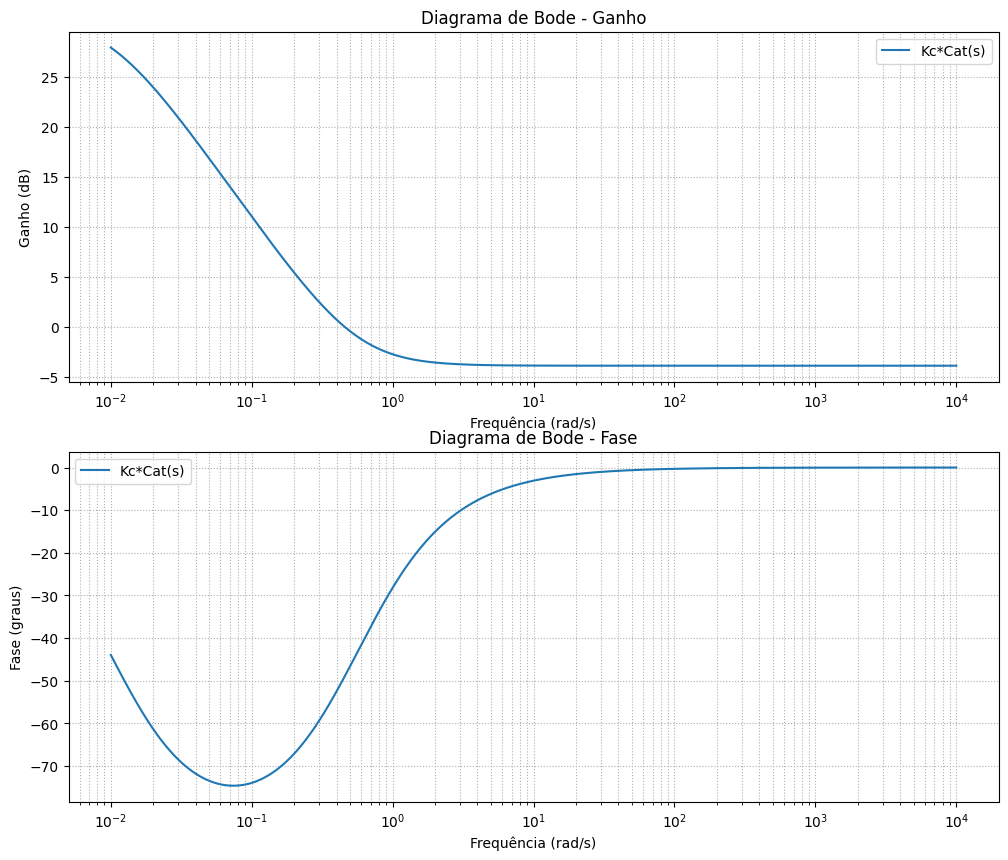

In [72]:
obter_plot_bode({"Kc*Cat(s)":Cat['scipy']})

## <font style='font-size: 20px;'> Simulação e plot do compensador de atraso </font> <hr style='line: 2px solid;'>

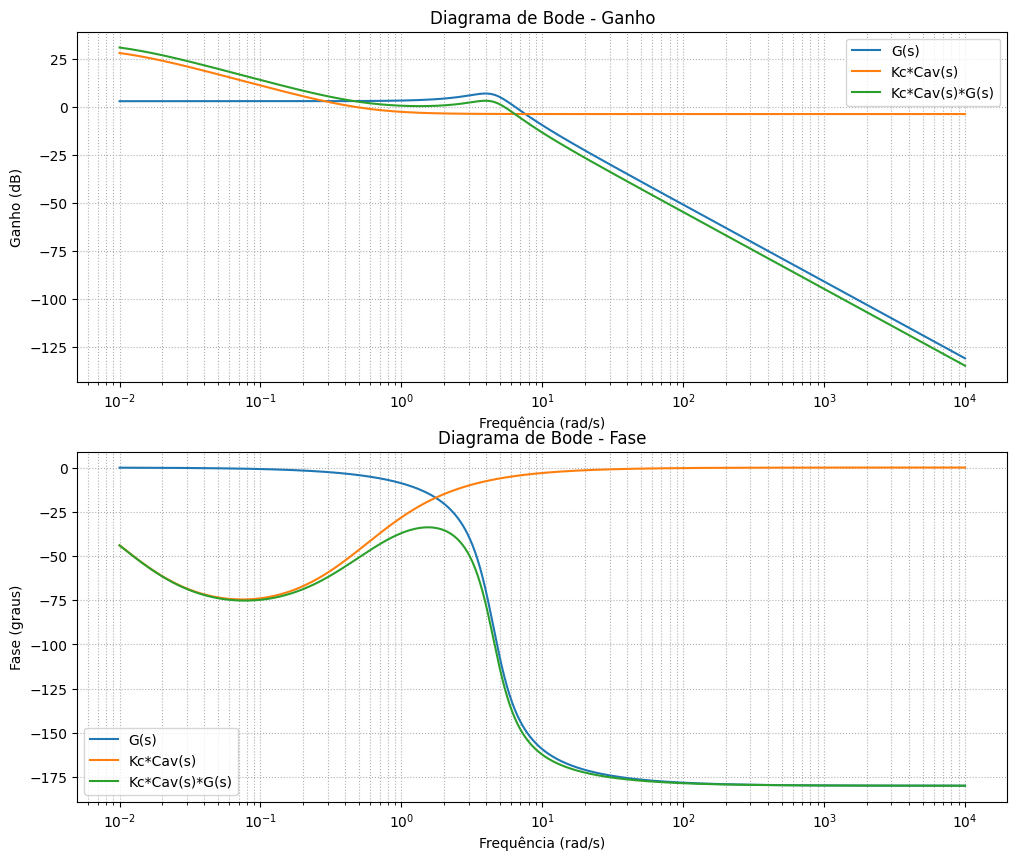

In [73]:
Kc_Cat_G = obter_cascata(Cat['scipy'], G['scipy'])
obter_plot_bode({'G(s)':G['scipy'], 'Kc*Cav(s)':Cat['scipy'], 'Kc*Cav(s)*G(s)':Kc_Cat_G})

In [74]:
malha_aberta = G['control'] * Cat['control']
print(malha_aberta)


           1804 s + 991
----------------------------------
100 s^3 + 302 s^2 + 2026 s + 20.22



In [75]:
malha_aberta = obter_sistema(num=[1804, 991], den=[100, 302, 2026, 20.22])
malha_aberta['dados']


           1804 s + 991
----------------------------------
100 s^3 + 302 s^2 + 2026 s + 20.22

Zeros:
-0.5493+0.0000j
Polos:
-1.5050+4.2385j
-1.5050-4.2385j
-0.0100+0.0000j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,56.795971,NaN,5.346801


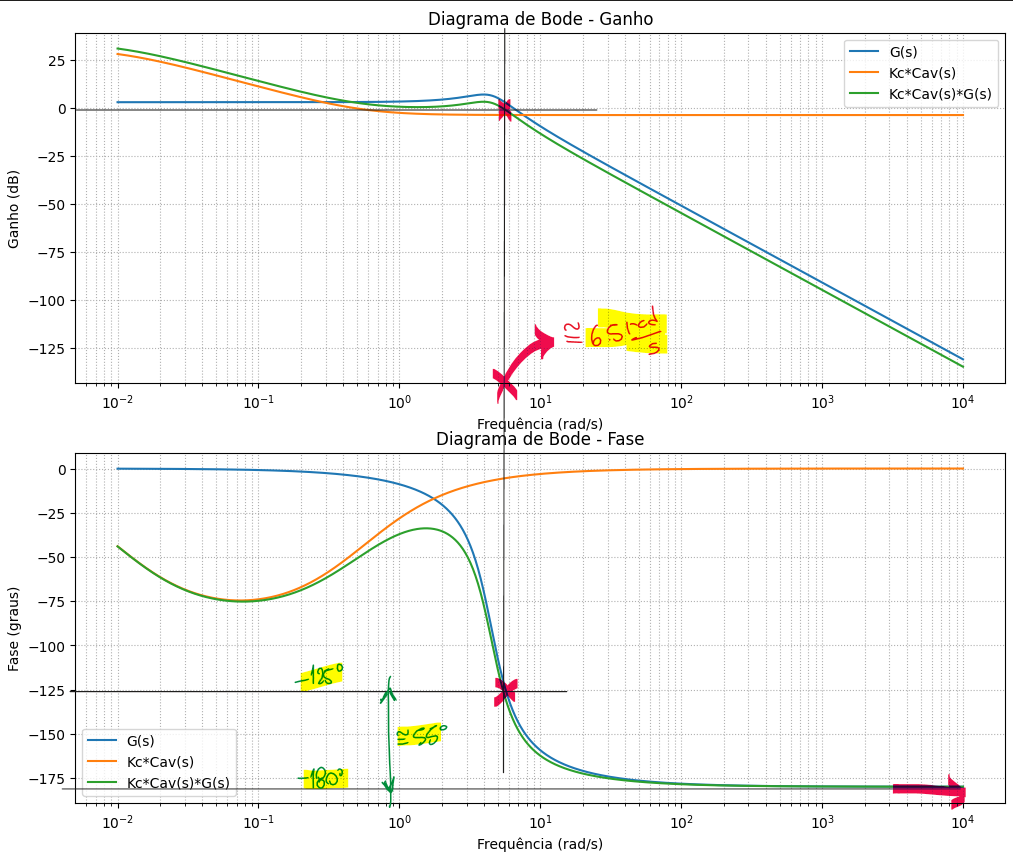

## <font style='font-size: 20px;'> Malha fechada </font> <hr style='line: 2px solid;'>

In [76]:
malha_fechada_atraso = obter_malha([G['control'], Cat['control']], close=True)
obter_parametros_sistema(sys=malha_fechada)


          1804 s + 991
---------------------------------
100 s^3 + 302 s^2 + 3829 s + 1011

Zeros:
-0.5494+0.0000j
Polos:
-1.3751+5.9715j
-1.3751-5.9715j
-0.2693+0.0000j


,Valor
RiseTime,0.0143
SettlingTime,0.1593
SettlingMin,0.9344
SettlingMax,1.1637
Overshoot,18.7406
Undershoot,0.0000
Peak,1.1637
PeakTime,0.0347
SteadyStateValue,0.9800
Erro(%),0.02


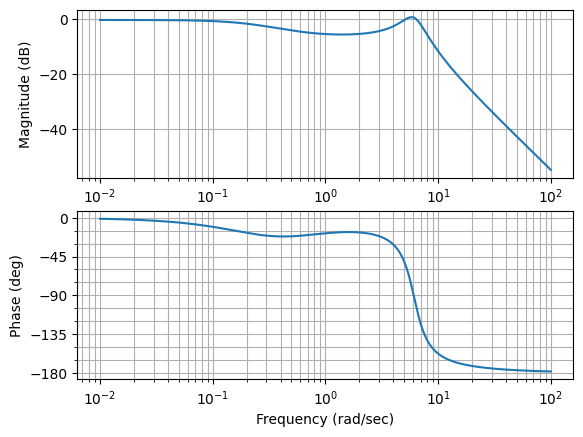

In [77]:
malha_fechada_atraso = ct.bode(malha_fechada_atraso, Hz=False, dB=True)

# QUESTÃO 4.c

## <font style='font-size: 20px;'> Cálculo do compensador de atraso e avanço </font> <hr style='line: 2px solid;'>

O ganho necessário é o mesmo, o que precisamos agora é projetar um controlador de atraso para reduzir o ganho em altas frequências depois um controlador de avanço para satisfazer as especificações de margem. Ou seja, vamos:

- Aumentar a margem de fase com compensador de avanço e
- Diminuir o ganho em altas frequências com compensador de atraso.

Relembrando nosso sistema já com ganho.


In [78]:
KcG = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885*35.2899)
KcG['dados']


         991
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,5.529034,NaN,31.726731


A tática é supor que toda a margem de fase de $55°$ será fornecida pelo compensador de avanço e que o a diferença para -180° seja preenchida pelo compensador de atraso, logo: $-174.5° -5.5° +55° = -125°$. Em outras palavras, queremos a frequência de corte onde a fase é $-5.5°$, pois isso somado à $-174.5°$ é $-180°$, o que deixa toda a compensação para o de avanço.

In [79]:
obter_valor_bode(KcG['scipy'], criterio="fase", valor=-5.5, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,0.63358,-5.494406,33.938068


No nosso caso, a frequência está por volta de $0.6336 \frac{rad}{s}$. Considerando esse ponto, precisamos de um ganho $-31.7267 dB$, para cancelar com o ganho e ter o frequência de corte nessa fase. Ou seja: 

Como a prática é escolher o zero do controlador uma década abaixo, temos: 

$$ s = -\frac{1}{T_2} = -0.5494 → \boxed{T_2 = 1.8201}$$

$\alpha$ é dado pelo compensador de avanço. Considerando $\phi_m=55°$. Logo temos:

$$ sen (55°) = 0.8191 = \frac{1-\alpha}{1+\alpha} → \boxed{\alpha = 10.0558} $$

In [80]:
Cat_2 = obter_compensador(T=1.8201, alpha=10.0558, kc=35.2899)
Cat_2['dados']


64.23 s + 35.29
---------------
  18.3 s + 1

Zeros:
-0.5494+0.0000j
Polos:
-0.0546+0.0000j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Compensador de atraso,inf,inf,NaN,NaN


Já $\omega_m$ deve ocorrer na frequência de corte, ou seja:

$$\omega_m = \frac{1}{\sqrt{\alpha}T_1} → \boxed{T_1 = 0.5771}$$

In [81]:
Cav_2 = obter_compensador(T=5, alpha=10.0558, kc=1)
Cav_2['dados']


  5 s + 1
-----------
50.28 s + 1

Zeros:
-0.2000+0.0000j
Polos:
-0.0199+0.0000j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Compensador de atraso,inf,inf,NaN,NaN


## <font style='font-size: 20px;'> Simulação e plot do compensador de atraso e avanço </font> <hr style='line: 2px solid;'>

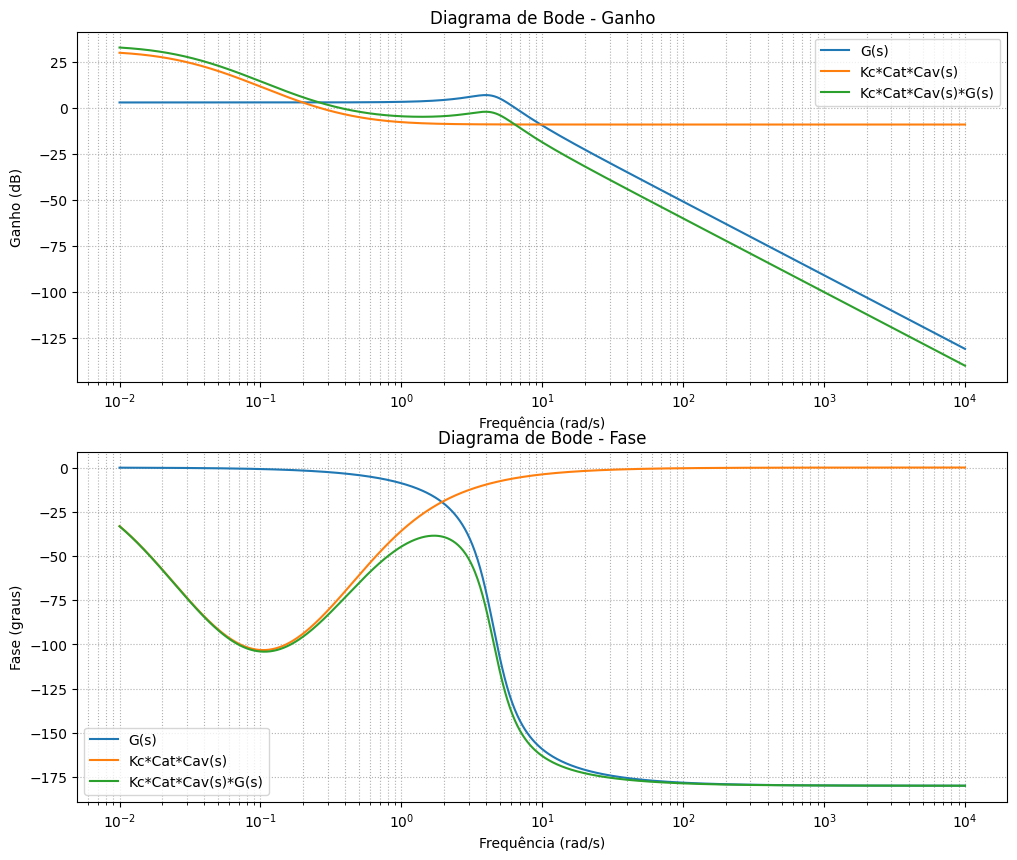

In [82]:
Kc_Cat2_Cav2 = obter_cascata(Cat_2['scipy'], Cav_2['scipy']) # obter a cascata dos dois compensadores
Kc_Cat2_Cav2_G = obter_cascata(Kc_Cat2_Cav2, G['scipy']) # obter a cascata do sistema e dos dois compensadores
obter_plot_bode({'G(s)':G['scipy'], 'Kc*Cat*Cav(s)': Kc_Cat2_Cav2, 'Kc*Cat*Cav(s)*G(s)':Kc_Cat2_Cav2_G})

In [128]:
malha_aberta = G['control'] * Cat_2['control'] * Cav_2['control'] # obtento a mesma cascata com outra estrutura de dados
print(malha_aberta) # printando para poder ver numerador e denominador


               9018 s^2 + 6759 s + 991
-----------------------------------------------------
920.2 s^4 + 2838 s^3 + 1.882e+04 s^2 + 1390 s + 20.22



In [129]:
malha_aberta = obter_sistema(num=[9018, 6759, 991], den=[920.2, 2838, 18820,1390, 20.22]) # obtendo os polos e zeros
malha_aberta['dados'] # margens do sistema no domínio da frequência


               9018 s^2 + 6759 s + 991
-----------------------------------------------------
920.2 s^4 + 2838 s^3 + 1.882e+04 s^2 + 1390 s + 20.22

Zeros:
-0.5495+0.0000j
-0.2000+0.0000j
Polos:
-1.5048+4.2382j
-1.5048-4.2382j
-0.0546+0.0000j
-0.0199+0.0000j


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,103.018919,NaN,0.361371


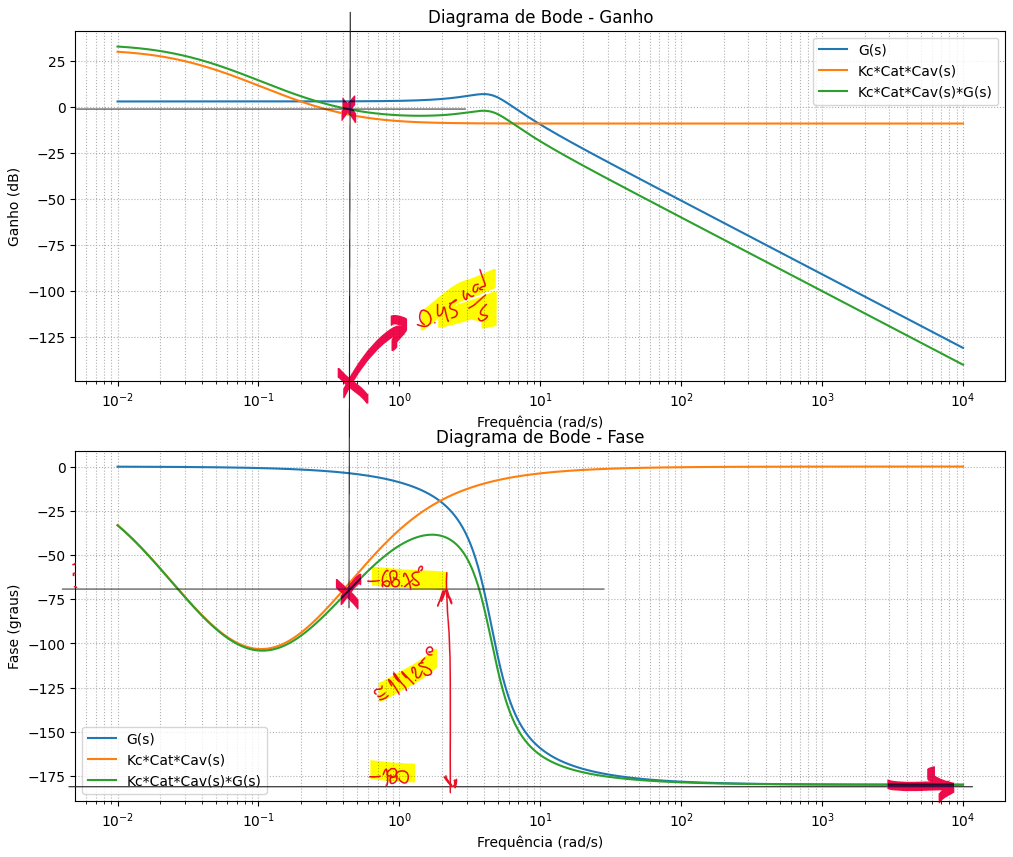

## <font style='font-size: 20px;'> Malha fechada </font> <hr style='line: 2px solid;'>


              9018 s^2 + 6759 s + 991
----------------------------------------------------
920.2 s^4 + 2838 s^3 + 2.784e+04 s^2 + 8149 s + 1011

Zeros:
-0.5494+0.0000j
-0.2000+0.0000j
Polos:
-1.3931+5.2385j
-1.3931-5.2385j
-0.1489+0.1234j
-0.1489-0.1234j


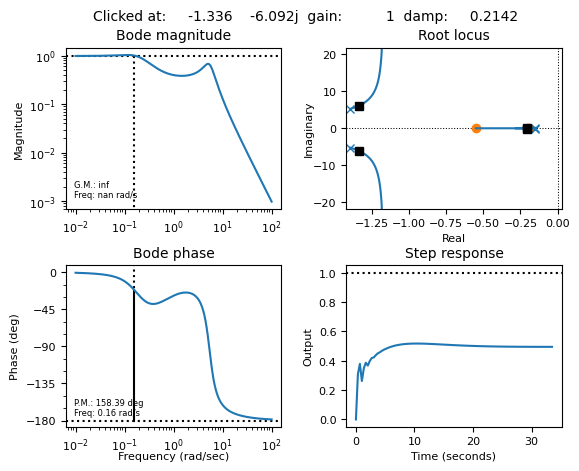

In [95]:
malha_fechada_avanco_atraso = obter_malha([G['control'], Cat_2['control'], Cav_2['control']], close=True)
ct.sisotool(malha_fechada_avanco_atraso)

# QUESTÃO 4.d

c:\Users\Mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\control\freqplot.py:943: UserWarning: number of encirclements was a non-integer value; this can happen is contour is not closed, possibly based on a frequency range that does not include zero.
  warnings.warn(


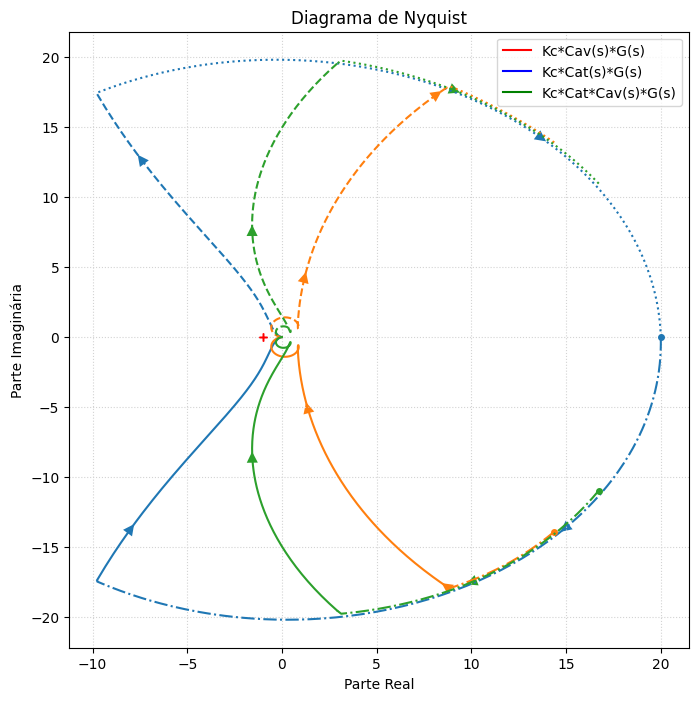

In [86]:
Kc_Cav_G = G['control'] * Cav['control']
Kc_Cat_G = G['control'] * Cat['control']
Kc_Cat2_Cav2_G = G['control'] * Cat_2['control'] * Cav_2['control']

obter_plot_nyquist({'Kc*Cav(s)*G(s)':Kc_Cav_G, 'Kc*Cat(s)*G(s)':Kc_Cat_G, 'Kc*Cat*Cav(s)*G(s)':Kc_Cat2_Cav2_G})

# QUESTÃO 4.e

Aqui vamos só produzir as malhas fechadas novamente, para organização.

In [121]:
Kc_Cav_G = [G['control'],Cav['control']]
Kc_Cat_G = [G['control'], Cat['control']]
Kc_Cat2_Cav2_G = [G['control'], Cat_2['control'], Cav_2['control']]

G_closed = obter_malha([G['control']], close=True)
Kc_Cav_G_closed = obter_malha(Kc_Cav_G, close=True)
Kc_Cat_G_closed = obter_malha(Kc_Cat_G, close=True)
Kc_Cat2_Cav2_G_closed = obter_malha(Kc_Cat2_Cav2_G, close=True)


       28.08
--------------------
s^2 + 3.009 s + 48.3

Zeros:
Polos:
-1.5047+6.7853j
-1.5047-6.7853j

              92.66 s + 991
-----------------------------------------
0.006947 s^3 + 1.021 s^2 + 95.81 s + 1011

Zeros:
-10.6952+0.0000j
Polos:
-67.5011+87.2969j
-67.5011-87.2969j
-11.9533+0.0000j

          1804 s + 991
---------------------------------
100 s^3 + 302 s^2 + 3829 s + 1011

Zeros:
-0.5494+0.0000j
Polos:
-1.3751+5.9715j
-1.3751-5.9715j
-0.2693+0.0000j

              9018 s^2 + 6759 s + 991
----------------------------------------------------
920.2 s^4 + 2838 s^3 + 2.784e+04 s^2 + 8149 s + 1011

Zeros:
-0.5494+0.0000j
-0.2000+0.0000j
Polos:
-1.3931+5.2385j
-1.3931-5.2385j
-0.1489+0.1234j
-0.1489-0.1234j


                    Valor
Parâmetro                
RiseTime           0.1807
SettlingTime       2.4580
SettlingMin        0.4377
SettlingMax        0.8706
Overshoot         49.7662
Undershoot         0.0000
Peak               0.8706
PeakTime           0.4699
SteadyStateValue   0.5813
                    Valor
Parâmetro                
RiseTime           0.0143
SettlingTime       0.1593
SettlingMin        0.9344
SettlingMax        1.1637
Overshoot         18.7406
Undershoot         0.0000
Peak               1.1637
PeakTime           0.0347
SteadyStateValue   0.9800


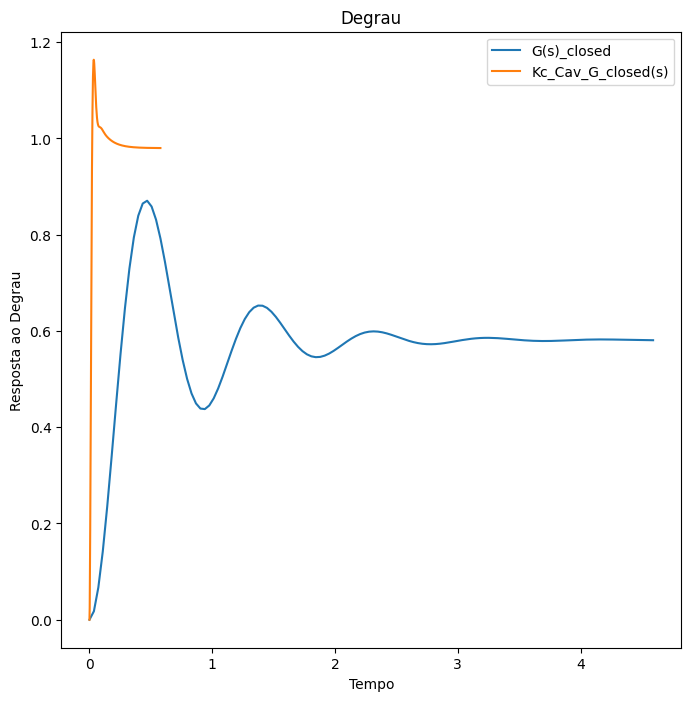

In [124]:
obter_plot_degrau({'G(s)_closed':G_closed, 'Kc_Cav_G_closed(s)':Kc_Cav_G_closed})

                    Valor
Parâmetro                
RiseTime           0.1807
SettlingTime       2.4580
SettlingMin        0.4377
SettlingMax        0.8706
Overshoot         49.7662
Undershoot         0.0000
Peak               0.8706
PeakTime           0.4699
SteadyStateValue   0.5813
                    Valor
Parâmetro                
RiseTime           6.0238
SettlingTime      12.1295
SettlingMin        0.8828
SettlingMax        0.9800
Overshoot          0.0000
Undershoot         0.0000
Peak               0.9795
PeakTime          25.6522
SteadyStateValue   0.9800


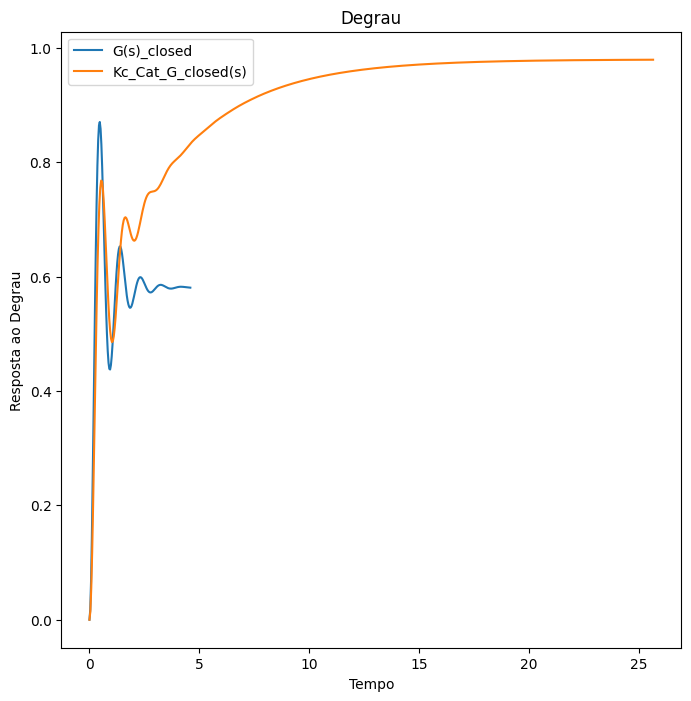

In [125]:
obter_plot_degrau({'G(s)_closed':G_closed, 'Kc_Cat_G_closed(s)':Kc_Cat_G_closed})

                    Valor
Parâmetro                
RiseTime           0.1807
SettlingTime       2.4580
SettlingMin        0.4377
SettlingMax        0.8706
Overshoot         49.7662
Undershoot         0.0000
Peak               0.8706
PeakTime           0.4699
SteadyStateValue   0.5813
                    Valor
Parâmetro                
RiseTime           5.4684
SettlingTime      24.2370
SettlingMin        0.8838
SettlingMax        1.0470
Overshoot          6.8399
Undershoot         0.0000
Peak               1.0470
PeakTime          13.5783
SteadyStateValue   0.9800


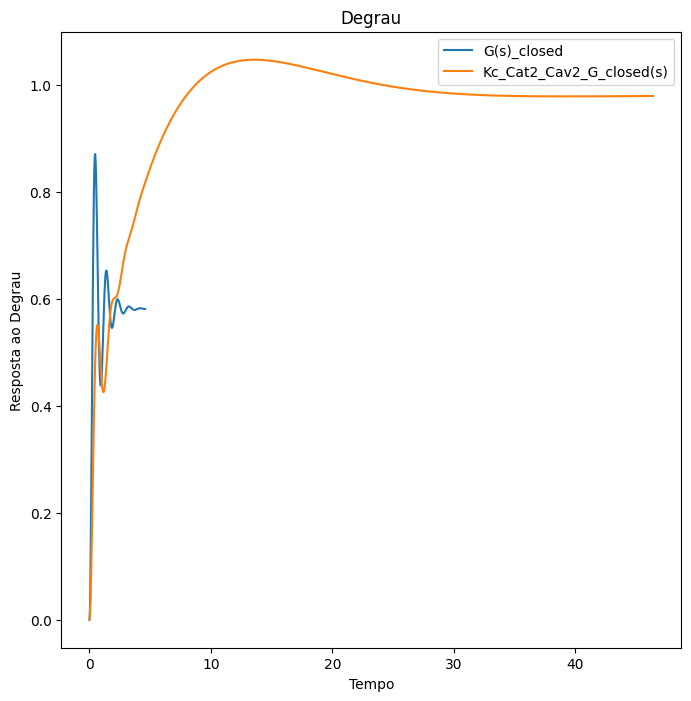

In [126]:
obter_plot_degrau({'G(s)_closed':G_closed, 'Kc_Cat2_Cav2_G_closed(s)':Kc_Cat2_Cav2_G_closed})

# Funções feitas sob medida para simulação

In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.signal as signal
import numpy as np
import pandas as pd
import control as ct
import scipy as sp

def obter_sistema(zeta=None, wn=None, k=None, num=None, den=None):
    if num is not None and den is not None:
        sc_tf = ct.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    elif zeta is not None and wn is not None and k is not None:
        num = [k*wn**2]
        den = [1, 2*zeta*wn, wn**2]
        sc_tf = signal.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer os coeficientes da função de segunda ordem ou os coeficientes num e den.")

    # gm, pm, wg, wp = ct.margin(ct_tf)
    # df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    # df.loc['Sistema'] = [gm, pm, wg, wp]
    
    print(ct_tf)
    print("Zeros:")
    zeros = np.round(ct.zero(ct_tf), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    print("Polos:")
    polos = np.round(ct.pole(ct_tf), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")
    
    # return {"scipy":sc_tf, "control":ct_tf, "dados":df}
    return {"scipy":sc_tf, "control":ct_tf}

def obter_compensador(alpha, T, kc):
    
    num = [kc*T, kc*1]
    den = [alpha * T, 1]
    sc_tf = signal.TransferFunction(num, den)
    ct_tf = ct.TransferFunction(num, den)
    gm, pm, wg, wp = ct.margin(ct_tf)

    df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    if alpha > 1:   df.loc['Compensador de atraso'] = [gm, pm, wg, wp]
    elif alpha < 1: df.loc['Compensador de avanço'] = [gm, pm, wg, wp]
    else:           df.loc['Não é compensador'] = [gm, pm, wg, wp]
    print(ct_tf)
    print("Zeros:")
    zeros = np.round(ct.zero(ct_tf), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    print("Polos:")
    polos = np.round(ct.pole(ct_tf), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")

    return {"scipy":sc_tf, "control":ct_tf, "dados":df}

def obter_parametros_sistema(num=None, den=None, sys=None, acomodacao=0.02):
    if sys is not None:
        sistema = sys
    elif num is not None and den is not None:
        sistema = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer o sistema ou o numerador e o denominador.")
    info_sistema = ct.step_info(sistema, SettlingTimeThreshold=acomodacao)
    df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
    df_sistema.index.name = 'Parâmetro'
    df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
    e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', 'Valor']):.4f}")
    df_adicional = pd.DataFrame({'Valor': [e_ss_atual]}, index=['Erro(%)'])
    df_sistema = pd.concat([df_sistema, df_adicional])
    # df_sistema = df_sistema.drop(['SettlingMin', 'SettlingMax', 'Undershoot'])
    return df_sistema

def obter_valor_bode(sistema, criterio, valor, resolucao):

    w = np.logspace(-2, 3, num=resolucao)  # Definir o array de frequências com mais pontos
    omega, mag, phase = signal.bode(sistema, w=w)   # produz a simulação de Bode

    # verifica qual critério o usuário escolheu e retorna o valores com base nele
    if criterio == "frequencia":
        indice = np.argmin(np.abs(omega - valor))
    elif criterio == "fase":
        valor_rad = np.deg2rad(valor)
        indice = np.argmin(np.abs(phase - valor))
    elif criterio == "ganho":
        indice = np.argmin(np.abs(mag - valor))
    frequencia = omega[indice]
    fase = phase[indice]
    ganho = mag[indice]

    # produz uma tabela (Dataframe) para melhor visualização dos resultados
    df = pd.DataFrame({"Frequência (rad/s)": [frequencia],"Fase (graus)": [fase],"Ganho (dB)": [ganho]}, index=["valores"])

    return df

def obter_plot_bode(transfer_functions):
    
    # Frequências para o cálculo do Bode
    w = np.logspace(-2, 4, num=1000)

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    for name, transfer_function in transfer_functions.items():

        # Obter os dados do diagrama de Bode
        omega, mag, phase = signal.bode(transfer_function,w=w)

        # Plot do diagrama de ganho
        ax1.semilogx(omega, mag, label=name)

        # Plot do diagrama de fase
        ax2.semilogx(omega, phase, label=name)

        # 20*np.log10(mag)
        # phase*(180/np.pi)

    ax1.set_xlabel('Frequência (rad/s)')
    ax1.set_ylabel('Ganho (dB)')
    ax1.set_title('Diagrama de Bode - Ganho')
    ax1.grid(True, which='both', linestyle='dotted')
    ax1.legend()

    ax2.set_xlabel('Frequência (rad/s)')
    ax2.set_ylabel('Fase (graus)')
    ax2.set_title('Diagrama de Bode - Fase')
    ax2.grid(True, which='both', linestyle='dotted')
    ax2.legend()

    # Retorna a figura
    # return fig

def obter_plot_nyquist(transfer_functions, colors=['red', 'blue', 'green']):
    # Frequências para o cálculo do Nyquist
    w = np.logspace(-2, 4, num=1000)

    # Criação do plot
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        # Cálculo do diagrama de Nyquist
        response = ct.nyquist(transfer_function, omega=w, color=colors[i])

        # Plot dos pontos do diagrama de Nyquist com cor específica
        ax.scatter(response.real, response.imag, color=colors[i], label=name)

    ax.set_xlabel('Parte Real')
    ax.set_ylabel('Parte Imaginária')
    ax.set_title('Diagrama de Nyquist')
    ax.grid(True, linestyle='dotted')
    ax.legend()
    plt.show()

def obter_plot_degrau(transfer_functions):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
        info_sistema = ct.step_info(transfer_function)
        df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
        df_sistema.index.name = 'Parâmetro'
        df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')

        tempo, resposta = ct.step_response(transfer_function)
        ax.plot(tempo, resposta, label=name)
        print(df_sistema)

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Resposta ao Degrau')
    ax.set_title('Degrau')
    ax.legend()

    # plt.tight_layout()
    plt.show()

def obter_malha(lista_tf, scipy=False, control=False, close=False):


    if scipy:

        num_total = [1]
        den_total = [1]

        for tf in lista_tf:
            num_total = np.convolve(num_total, tf.num) # convolui o numerador
            den_total = np.convolve(den_total, tf.den) # convolui o denominador

        tf_scipy = signal.TransferFunction(num_total, den_total) # obtem função objeto função de transferência no scipy
        tf_control = ct.TransferFunction(num_total, den_total) # obtem função objeto função de transferência no control

    if control:
        tf_control = ct.TransferFunction(1, 1)  # Inicializa a função de transferência da malha como 1 (sistema vazio)
        for tf in lista_tf:
            tf_control *= tf  # Multiplica a função de transferência da malha pelo sistema atual
        print(tf_control)
        tf_scipy = tf_control.returnScipySignalLTI()
        tf_scipy = tf_scipy[0][0]

    if close:
        tf_control = ct.feedback(tf_control)  # Realizar o feedback no objeto do Control
        tf_scipy = tf_control.returnScipySignalLTI()
        tf_scipy = tf_scipy[0][0]
    
    print("Forma padrão:")
    print("**************")
    print(tf_control)

    print("Zeros:")
    zeros = np.round(ct.zero(tf_control), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    
    print("Polos:")
    polos = np.round(ct.pole(tf_control), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")

    return {'scipy':tf_scipy, 'control':tf_control}

def obter_informacoes_bode(num=[],den=[], resolucao=1000, plot=False):

    # Simulação de Bode com scipy
    w = np.logspace(-2, 3, num=resolucao)
    tf_scipy = signal.TransferFunction(num, den)
    omega_scipy, mag_scipy, phase_scipy = signal.bode(tf_scipy, w=w)

    # Simulação de Bode com control
    w = np.logspace(-2, 3, num=10000)
    tf_control = ct.TransferFunction(num, den)
    mag_control, phase_control, omega_control = ct.bode(tf_control, Hz=False, dB=True, omega=w, plot=plot)

    # Pico de ressonância e sua frequência
    indice_pico = np.argmax(mag_scipy)
    pico_ressonancia = mag_scipy[indice_pico]
    frequencia_pico = omega_scipy[indice_pico]

    # Ganho em baixas frequências
    ganho_baixas_frequencias = mag_control[0]

    # Banda de passagem
    indice_ganho_nulo = np.argmin(np.abs(mag_control))
    indice_3db = np.where(mag_control >= ganho_baixas_frequencias - 3)[0][0] # castrucci. fig 5-40
    frequencia_corte = omega_control[indice_3db]
    banda_passagem = frequencia_corte - frequencia_pico

    # Margens de ganho e fase
    gm, pm, wg, wp = ct.margin(tf_control)

    data = {
        "Pico de ressonância (dB)": round(pico_ressonancia, 4),
        "Frequência do pico de ressonância (rad/s)": round(frequencia_pico, 4),
        "Ganho em baixas frequências (dB)": round(ganho_baixas_frequencias, 4),
        "Banda de passagem (rad/s) e corte": round(banda_passagem, 4),
        "Margem de Ganho (dB)": round(gm, 4),
        "Margem de Fase (graus)": round(pm, 4),
        "Frequência de Margem de Ganho (rad/s)": round(wg, 4),
        "Frequência de Margem de Fase (rad/s)": round(wp, 4)
    }

    df = pd.DataFrame(data, index=[0])
    return df

def obter_dados_a5():
    # Médias, valores máximos e variação máxima do dados 'a5.csv'
    data_dict={'Sobressinal': {'Média': 0.33011062039602557, 
                            'Valor Máximo': 0.39442231075697215, 
                            'Variação Máxima': 0.06431169036094658}, 
                'Coeficiente de Amortecimento (ζ)': {'Média': 0.33455454545454544, 
                                                    'Valor Máximo': 0.4029, 
                                                    'Variação Máxima': 0.06834545454545454}, 
                'Frequência Natural não Amortecida (ω_d)': {'Média': 4.778245454545455, 
                                                            'Valor Máximo': 7.4458, 
                                                            'Variação Máxima': 2.6675545454545455}, 
                'Frequência Natural Amortecida (ω_n)': {'Média': 4.497063636363636, 
                                                        'Valor Máximo': 6.9813, 
                                                        'Variação Máxima': 2.484236363636364}, 
                'Ganho': {'Média': 1.3885018106236868,
                        'Valor Máximo': 2.3224299065420557, 
                        'Variação Máxima': 0.9339280959183689}}
    df_medias_copiado = pd.DataFrame(data_dict)
    return df_medias_copiado

In [24]:
num_s = [2, 1]
den_s = [0.006, 3]
tf_scipy_1 = signal.TransferFunction(num_s, den_s, dt=0.0001)
tf_control = ct.TransferFunction(num_s, den_s)
print(tf_scipy_1.num)
print(tf_scipy_1.den)
print(tf_control)


num_total = np.convolve(num_total, tf.num) # convolui o numerador
den_total = np.convolve(den_total, tf.den) # convolui o denominador

[333.33333333 166.66666667]
[  1. 500.]

  2 s + 1
-----------
0.006 s + 3

